In [180]:
import cv2
import numpy as np
import open3d
from open3d import JVisualizer

import matplotlib.pyplot as plt
import scipy, scipy.fftpack
import math
import time

In [123]:
#read the image
img_init = cv2.imread('sample_data/1.jpg')

In [124]:
#openCV uses BGR while matplotlib uses RGB
img_init = cv2.cvtColor(img_init, cv2.COLOR_BGR2RGB)

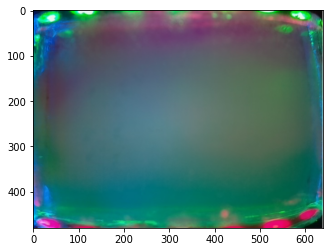

In [125]:
plt.imshow(img_init)

In [126]:
img = cv2.imread('sample_data/120.jpg')

In [127]:
#openCV uses BGR while matplotlib uses RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

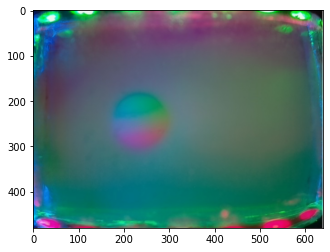

In [128]:
plt.imshow(img2)

In [129]:
#calculate the difference images
def calc_diff(img, img_init):
    red_diff = np.clip(img[:,:,0].astype(int)-img_init[:,:,0].astype(int),0,255)#.astype(np.uint8)
    green_diff = np.clip(img[:,:,1].astype(int)-img_init[:,:,1].astype(int),0,255)#.astype(np.uint8)
    blue_diff = np.clip(img[:,:,2].astype(int)-img_init[:,:,2].astype(int),0,255)#.astype(np.uint8)
    return red_diff, green_diff, blue_diff


In [130]:
red_diff, green_diff, blue_diff = calc_diff(img, img_init)

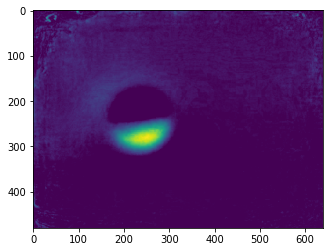

In [131]:
# we can see that the changes in red channel ( red light coming from bottom)is highlighted
plt.imshow(red_diff)

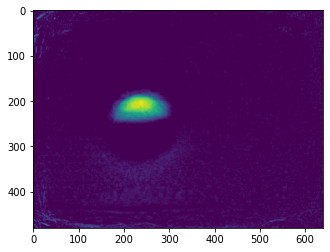

In [132]:
# we can see that the changes in green channel ( green light coming from top) is highlighted
plt.imshow(green_diff)

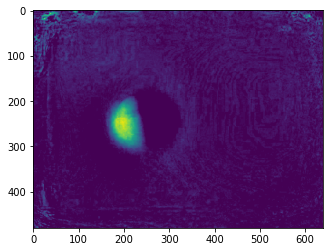

In [133]:
# we can see that the changes in green channel ( blue light coming from left) is highlighted

plt.imshow(blue_diff)

In [275]:
# define Poisson reconstruction function
# adapted from https://web.media.mit.edu/~raskar/photo/code.pdf
# Need to optimize, runs at 17Hz max on my computer (i7-7700 CPU @ 3.60GHz)
def poisson_reconstruct(grady, gradx, boundarysrc):

    # Laplacian
    gyy = grady[1:,:-1] - grady[:-1,:-1]
    gxx = gradx[:-1,1:] - gradx[:-1,:-1]
    f = np.zeros(boundarysrc.shape)
    f[:-1,1:] += gxx
    f[1:,:-1] += gyy

    # Boundary image
    boundary = boundarysrc.copy()
    boundary[1:-1,1:-1] = 0;

    # Subtract boundary contribution
    f_bp = -4*boundary[1:-1,1:-1] + boundary[1:-1,2:] + boundary[1:-1,0:-2] + boundary[2:,1:-1] + boundary[0:-2,1:-1]
    f = f[1:-1,1:-1] - f_bp

    
    # Discrete Sine Transform
    tt = scipy.fftpack.dst(f, norm='ortho')
    fsin = scipy.fftpack.dst(tt.T, norm='ortho').T
    
    # Eigenvalues
    (x,y) = np.meshgrid(range(1,f.shape[1]+1), range(1,f.shape[0]+1), copy=True)
    denom = (2*np.cos(math.pi*x/(f.shape[1]+2))-2) + (2*np.cos(math.pi*y/(f.shape[0]+2)) - 2)
    
    f = fsin/denom
    
    # Inverse Discrete Sine Transform
    tt = scipy.fftpack.idst(f, norm='ortho')
    img_tt = scipy.fftpack.idst(tt.T, norm='ortho').T
    
    # New center + old boundary
    result = boundary
    result[1:-1,1:-1] = img_tt

    return result

In [276]:

rec_img = poisson_reconstruct(green_diff-red_diff,blue_diff,np.zeros_like(green_diff))[::1,:]


In [277]:
# scale the gradient image to the range 0-255 if need to be used in opencv
#rec_img = rec_img.astype(np.uint8)

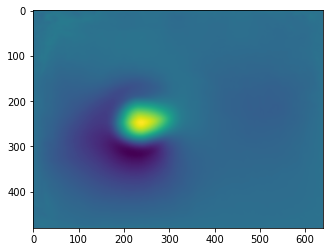

In [278]:
plt.imshow(rec_img)

In [279]:
#The values of the rec_img corresponds to the depth or deformation
print(rec_img.min(),rec_img.max())

-924 1542


In [280]:
# we can clip the negative values to zero, assuming we are ONLY PUSHING on the elastomer and NO PULLING
rec_img = rec_img.clip(0)

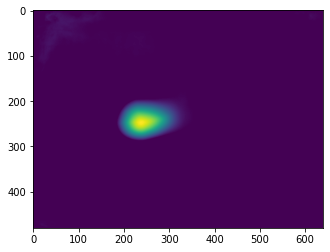

In [281]:
# Now it looks better
plt.imshow(rec_img)

In [282]:
#scale the value into mm ( NOTE: we assume the deformation is linear over small distanes and obeys Hook's Law )
# parameters are estimated approximately by trial and error experimentation
#the deformation of elastomer of 3 mm thickness is assumed to be in the range 0 - 0.0028
# and at max deformation (2.8mm), the rec_img max value is found to be 2000
rec_img =  np.interp(rec_img,(0,2000),(0,0.0028))

In [283]:
pcd = open3d.geometry.PointCloud()

In [284]:
# create the pointcloud and fill array
n = img.shape[1]
m = img.shape[0]

x = np.arange(n)
y = np.arange(m)
X, Y = np.meshgrid(x,y)

points = np.zeros([n * m, 3])
# map it to finger geometry
sensor_length = 0.045
sensor_width = 0.03
X_scl = np.interp(X,(0,(img.shape[1]-1)),(0,sensor_length))
Y_scl = np.interp(Y,(0,(img.shape[0]-1)),(0,sensor_width))

points[:, 0] = np.ndarray.flatten(X_scl )
points[:, 1] = np.ndarray.flatten(Y_scl)
points[:, 2] = np.ndarray.flatten(rec_img)

pcd.points = open3d.utility.Vector3dVector(points)

In [285]:
open3d.visualization.draw_geometries([pcd])

In [286]:
#threshold the points
threshold_height = 0.0015
pcd_thr = open3d.geometry.PointCloud()
thr_points = points[np.where(points[:,2]>threshold_height)]
pcd_thr.points =  open3d.utility.Vector3dVector(thr_points)

In [241]:
#display the thresholded pointcloud
open3d.visualization.draw_geometries([pcd_thr])

